In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import math
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

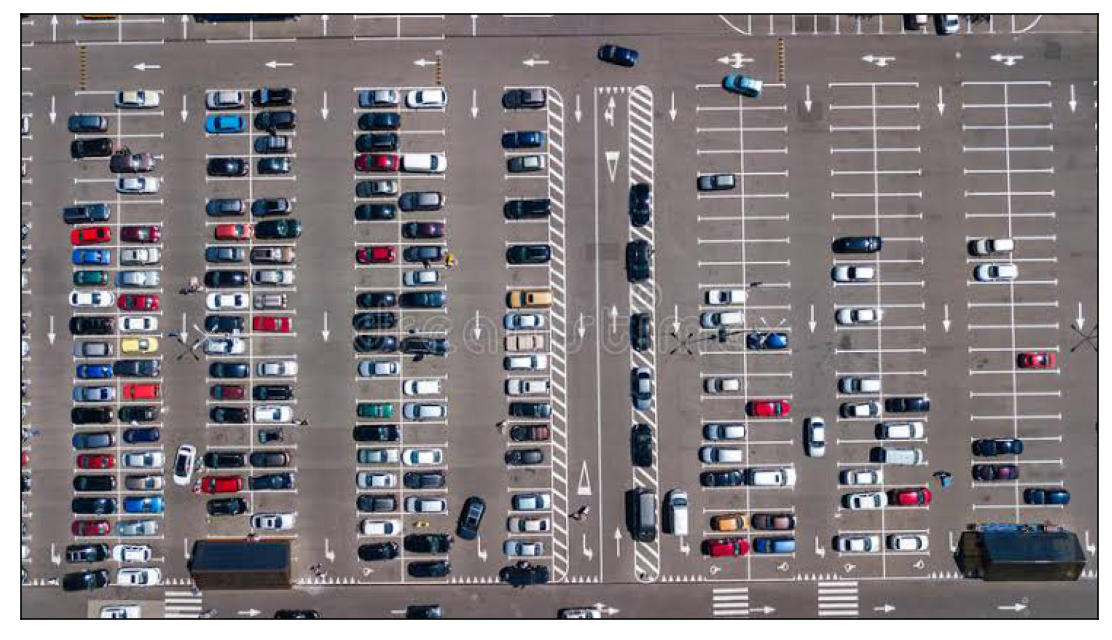

In [3]:
test_images = [plt.imread('img1.jpg')]
show_images(test_images)

In [4]:
global points
points = [] # end point of long edge - interior point of long edge - second interior point of short edge
closeCount = 0
def select_point(event,x,y,flags,param):
    global ix,iy
    if event == cv2.EVENT_LBUTTONDOWN: # captures left button down
        ix,iy = x,y
        print(ix,iy)
        points.append([ix,iy])
        if len(points) == 3:
            cv2.destroyWindow('image')
            cv2.destroyAllWindows()

cv2.namedWindow('image')
cv2.setMouseCallback('image', select_point)
cv2.imshow('image',test_images[0])

cv2.waitKey(0)     
cv2.destroyAllWindows()
longEdge = math.sqrt((points[1][1]-points[0][1])**2+(points[1][0]-points[0][0])**2) #width
shortEdge = math.sqrt((points[2][1]-points[1][1])**2+(points[2][0]-points[1][0])**2) #height
print(longEdge, shortEdge)
print(points)

231 342
261 343
262 359
30.01666203960727 16.0312195418814
[[231, 342], [261, 343], [262, 359]]


### Color Selection and Edge Detection

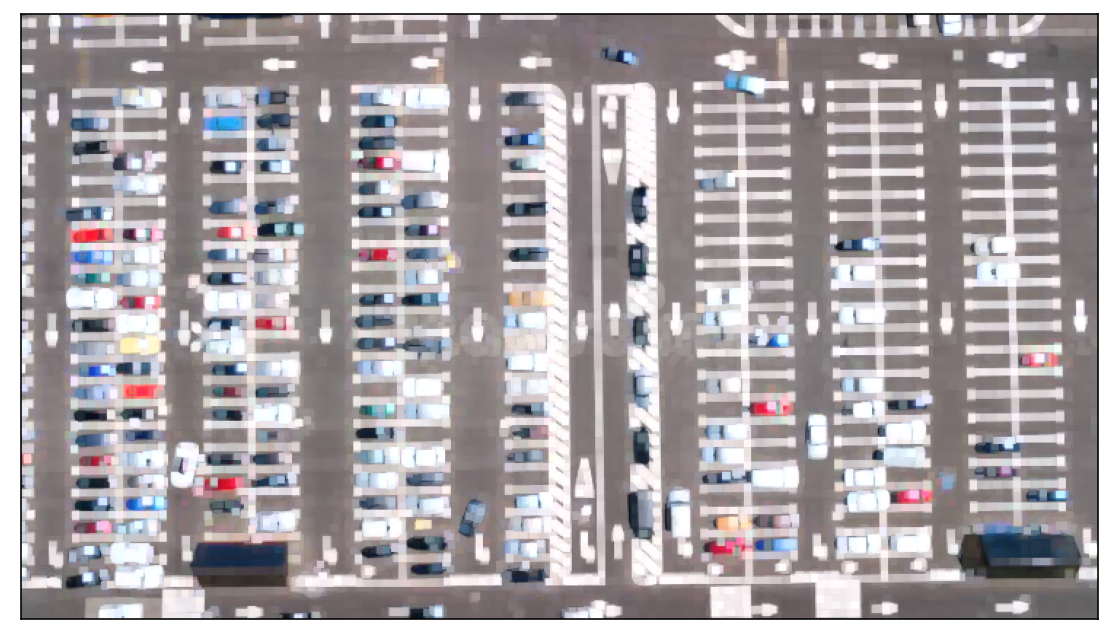

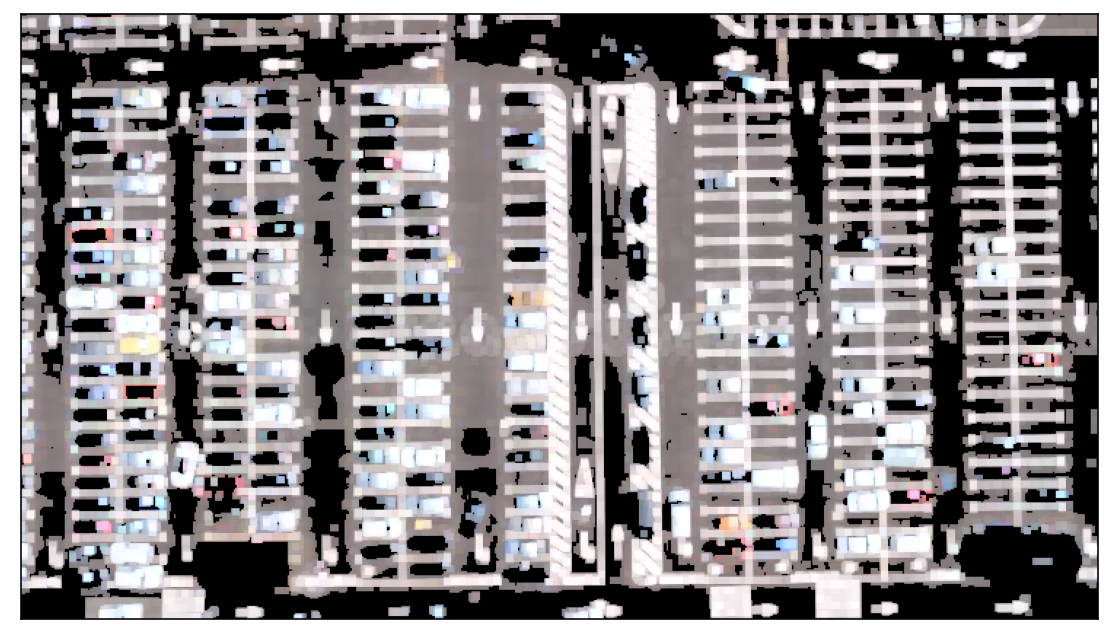

In [5]:
def dilation(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(image, kernel)
    #return cv2.GaussianBlur(image, (5,5), 0)

# image is expected be in RGB color space# image 
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([120, 120, 120])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked
gaus = list(map(dilation, test_images))
show_images(gaus)
white_yellow_images = list(map(select_rgb_white_yellow, gaus))
show_images(white_yellow_images)

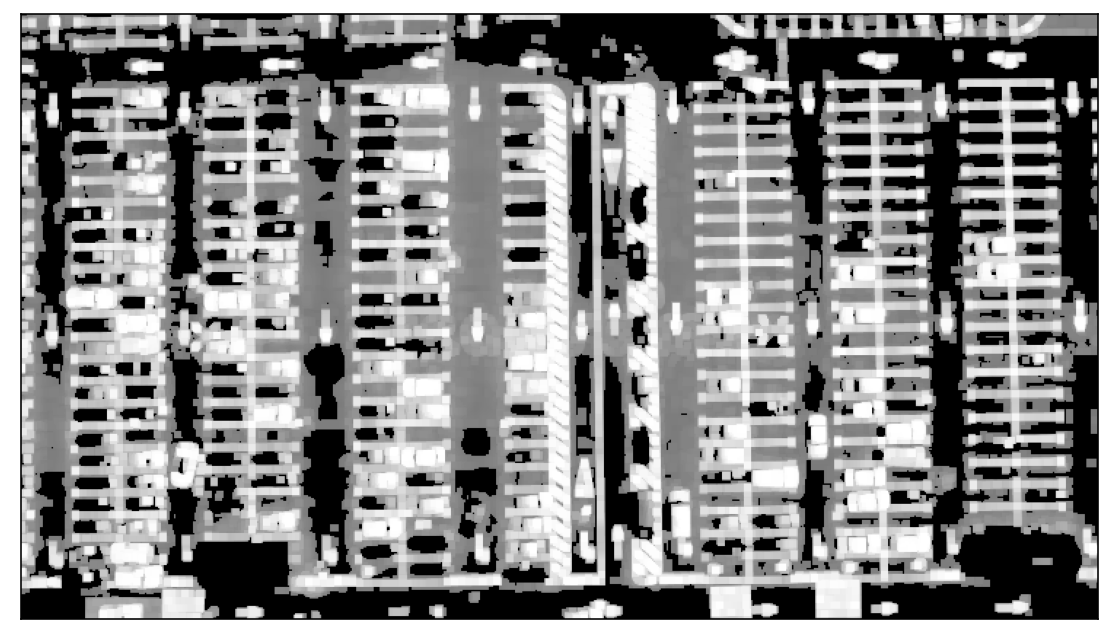

In [6]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

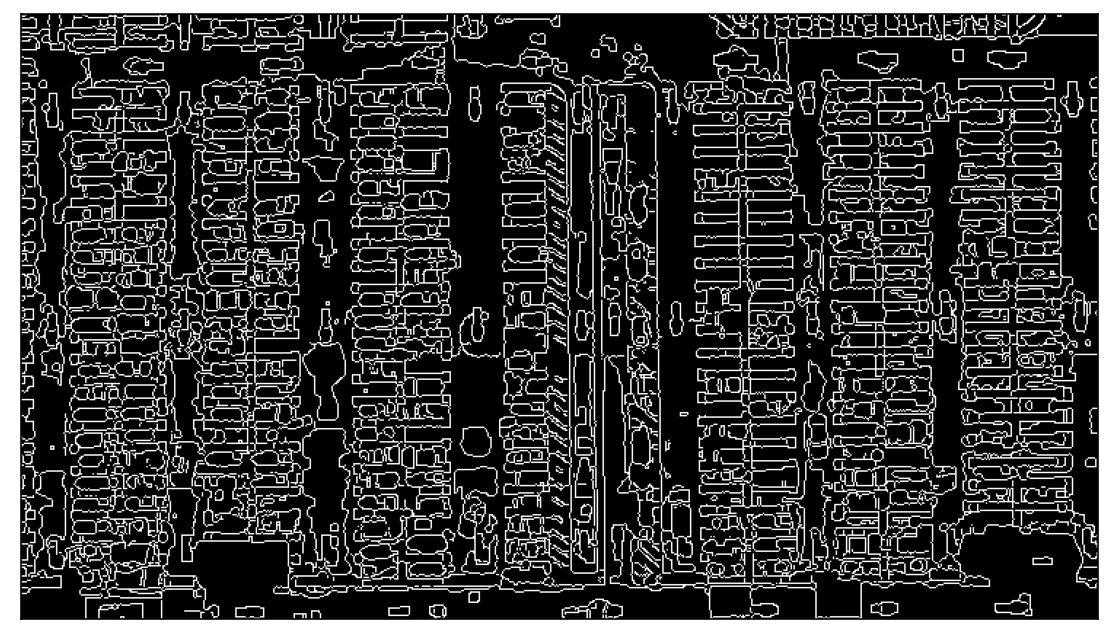

In [7]:
def detect_edges(image, low_threshold=50, high_threshold=200):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), gray_images))

show_images(edge_images)

### Identify area of interest

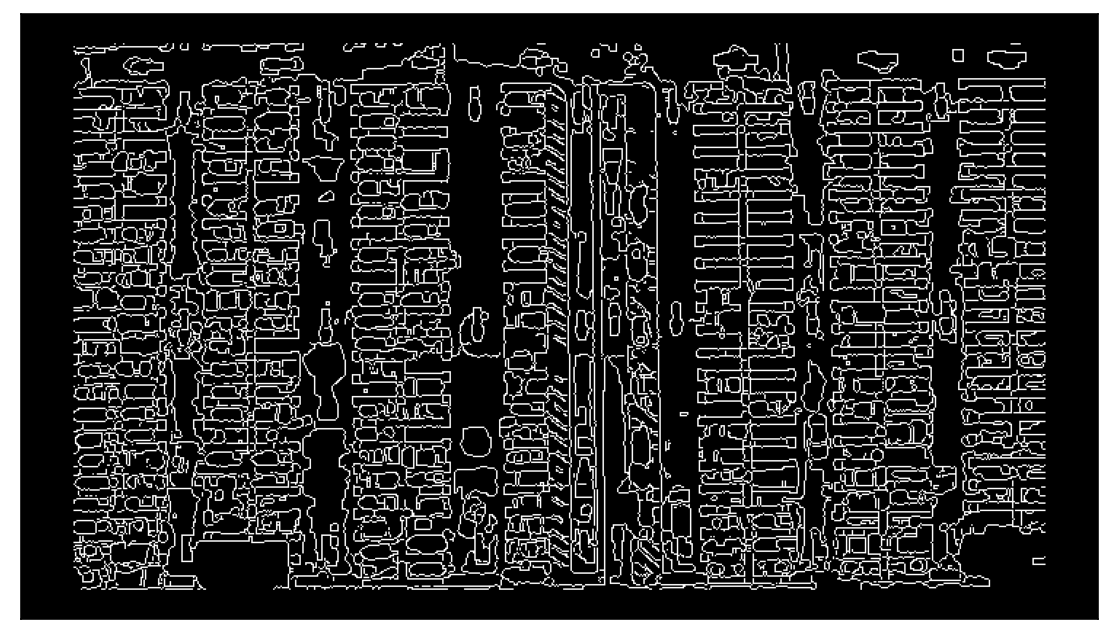

In [8]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    pt_1  = [cols*0.05, rows*0.95]
    pt_2 = [cols*0.05, rows*0.95]
    pt_3 = [cols*0.05, rows*0.95]
    pt_4 = [cols*0.05, rows*0.05]
    pt_5 = [cols*0.95, rows*0.05] 
    pt_6 = [cols*0.95, rows*0.95]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4, pt_5, pt_6]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

### Hough line transform

In [9]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4)


list_of_lines = list(map(hough_lines, roi_images))

[array([[[556, 218, 658, 218]],

       [[550, 121, 588, 121]],

       [[461,  82, 491,  82]],

       ...,

       [[267, 138, 280, 138]],

       [[ 45,  50,  62,  50]],

       [[ 71, 248,  86, 248]]], dtype=int32)]
 Number of lines detected:  292


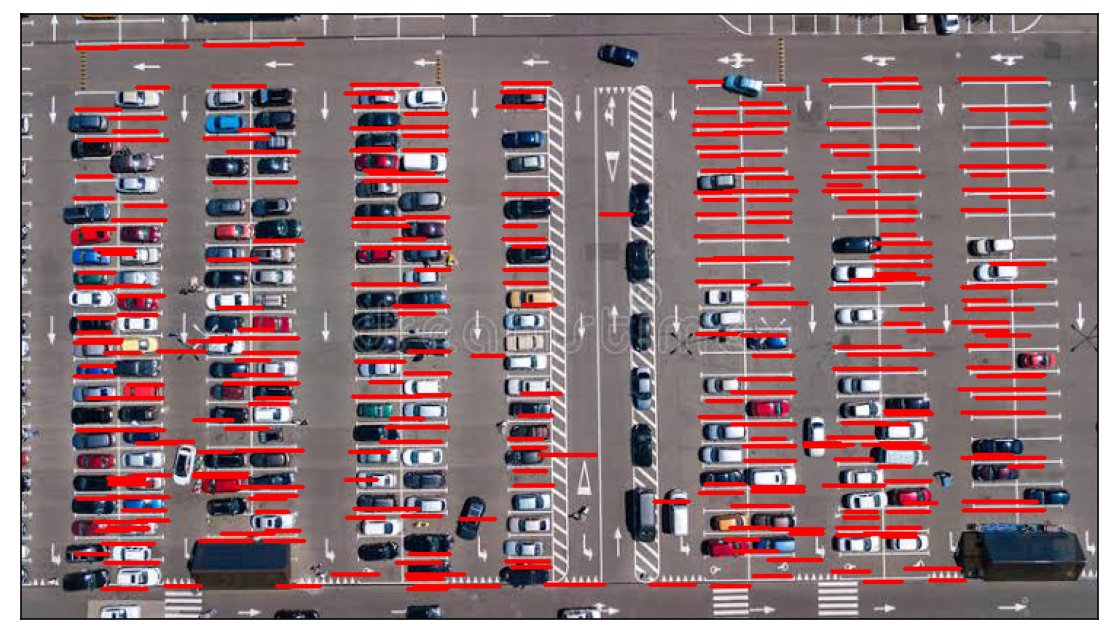

In [10]:
def draw_lines(image, lines, color=[255, 0, 0], zoomed=False, thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if not zoomed:
                if abs(y2-y1) <=1 and abs(x2-x1) >= (shortEdge + 5) * shortEdgeCoef and abs(x2-x1) <= longEdge * 2: #40 - 70 /20-55 || büyük: 20-60
                    cleaned.append((x1,y1,x2,y2))
                    cv2.line(image, (x1, y1), (x2, y2), color, thickness)
            else:
                if abs(y2-y1) <=1:
                    cleaned.append((x1,y1,x2,y2))
                    cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    """
    for i in cleaned:
        for j in cleaned:
            if i != j:
                if abs(i[1] - j[1]) <= 1 and abs(i[0] - j[0]) <= 1: # DELETE SO CLOSE ACCORDİNG TO Y
                    cleaned = [x for x in cleaned if x != i]
    
    for x in cleaned:
        cv2.line(image, (x[0], x[1]), (x[2], x[3]), color, thickness)
    """
    print(" Number of lines detected: ", len(cleaned))
    return image, len(cleaned)

print(list_of_lines)
line_images = []
shortEdgeCoef = 1/2 if shortEdge > 20 else 1
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines, zoomed=False)[0])
    
show_images(line_images)

### Identify rectangular blocks of parking

gap:  0.5
clus dist:  9.5156097709407
30.391304347826093
32.82857142857142
33.181818181818215
27.111111111111143
32.666666666666686
30.94545454545448
42.5
Num Parking Lanes:  7
 Number of lines detected:  6
 Number of lines detected:  8
 Number of lines detected:  5
 Number of lines detected:  4
 Number of lines detected:  8
 Number of lines detected:  17
 Number of lines detected:  1
 Number of lines detected:  1
 Number of lines detected:  20
 Number of lines detected:  23
 Number of lines detected:  18
 Number of lines detected:  14
 Number of lines detected:  6
 Number of lines detected:  22


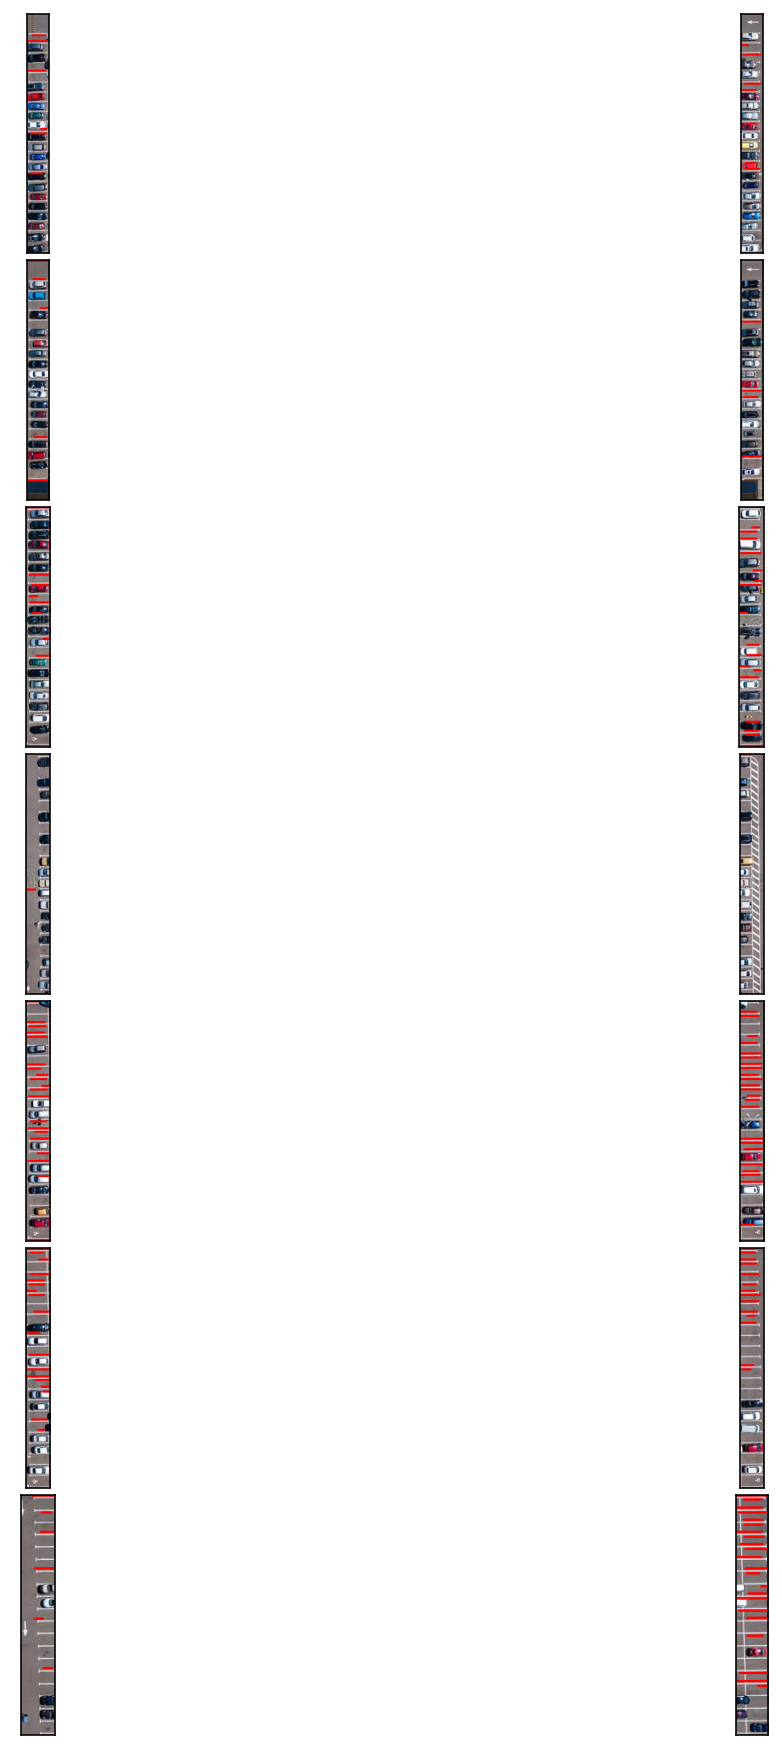

[6, 8, 5, 4, 8, 17, 1, 1, 20, 23, 18, 14, 6, 22]
rect:  34.20791089290121 22 102.6616543244901 394
img:  315 47 347 379
False
rect:  124.02592331526145 20 194.91693382759567 392
img:  315 47 347 379
False
rect:  226.26423500357313 48 297.50849226915415 394
img:  315 47 347 379
False
rect:  315.3021137914519 47 380.47566398632586 379
img:  315 47 347 379
True
rect:  462.7604471247853 46 533.4895528752147 392
img:  315 47 347 379
False
rect:  556.6778713672095 44 625.6857649964268 389
img:  315 47 347 379
False
rect:  630.853395842734 44 711.4158349264967 340
img:  315 47 347 379
False
rect:  34.20791089290121 22 102.6616543244901 394
img:  347 47 380 379
False
rect:  124.02592331526145 20 194.91693382759567 392
img:  347 47 380 379
False
rect:  226.26423500357313 48 297.50849226915415 394
img:  347 47 380 379
False
rect:  315.3021137914519 47 376.43571820171104 379
img:  347 47 380 379
True
rect:  462.7604471247853 46 533.4895528752147 392
img:  347 47 380 379
False
rect:  556.677871367

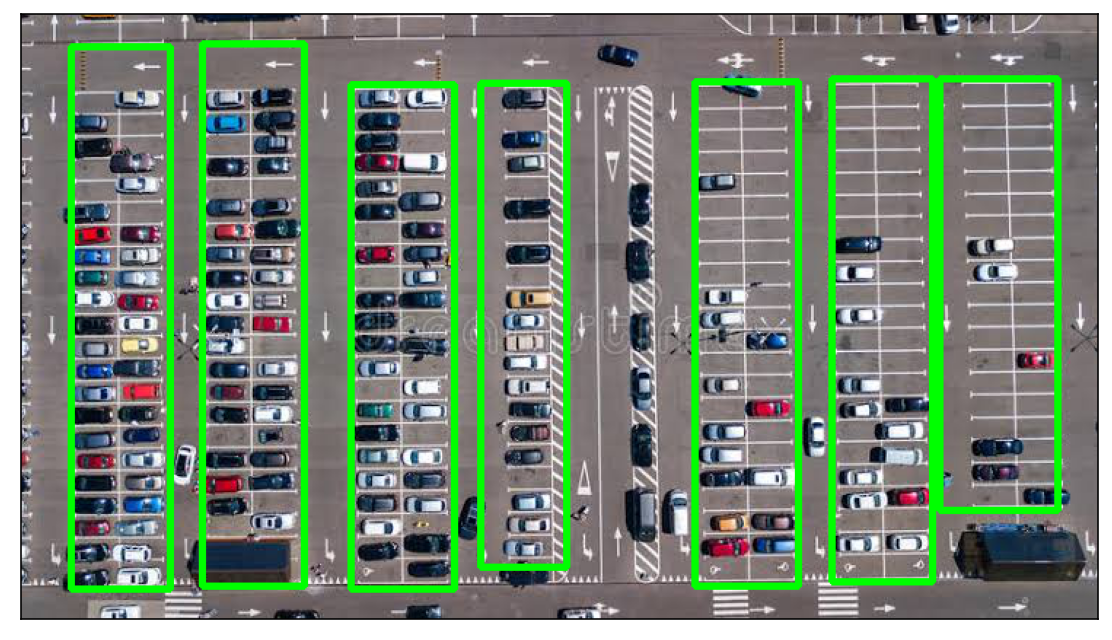

In [11]:
def doOverlap(l1X, l1Y, r1X, r1Y, l2X, l2Y, r2X, r2Y):
    if(l1X == r1X or l1Y == r1Y or l2X == r2X or l2Y == r2Y):
        return False
    if(l1X >= r2X or l2X >= r1X):
        return False
    if(r1Y <= l2Y or r2Y <= l1Y):
        return False
    return True

def identify_blocks(image, edge_image, lines, make_copy=True):
    if make_copy:
        new_image = np.copy(image)
    #Step 1: Create a clean list of lines
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=1 and abs(x2-x1) >= (shortEdge + 5) * shortEdgeCoef and abs(x2-x1) <= longEdge * 2: #20-55
                cleaned.append((x1,y1,x2,y2))
    """
    for i in cleaned:
        for j in cleaned:
            if i != j:
                if abs(i[1] - j[1]) <= 1 and abs(i[0] - j[0]) <= 1: # DELETE SO CLOSE ACCORDİNG TO Y
                    cleaned = [x for x in cleaned if x != i]
    """

    #Step 2: Sort cleaned by x1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(0, 1))
    
    #Step 3: Find clusters of x1 close together - clust_dist apart
    clusters = {}
    dIndex = 0
    clus_dist = shortEdge if shortEdge > 20 else shortEdge/2 + 1.5 #9 #15 #7
    print("clus dist: ", clus_dist)

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][0] - list1[i][0])
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])

        else:
            dIndex += 1

    #Step 4: Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > 15:
            cleaned = sorted(cleaned, key=lambda tup: tup[1])
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
    #         print(avg_y1, avg_y2)
            avg_x1 = 0
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 += tup[0]
                avg_x2 += tup[2]
            avg_x1 = avg_x1/len(cleaned)
            avg_x2 = avg_x2/len(cleaned)
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
    for rect in rects:
        print(rects[rect][2] - rects[rect][0])
    
    popALL = []
    for rect in rects:
        for rect2 in rects:
            if rects[rect] != rects[rect2]:
                overlap  =doOverlap(rects[rect][0],rects[rect][1],rects[rect][2],rects[rect][3],rects[rect2][0],rects[rect2][1],rects[rect2][2],rects[rect2][3])
                if overlap:
                    nX= rects[rect][2]-rects[rect][0]
                    nY = rects[rect][1]
                    sSide = math.sqrt((nX-rects[rect][0])**2 + (nY-rects[rect][1])**2)
                    lSide = math.sqrt((rects[rect][2]-nX)**2 + (rects[rect][3]-nY)**2)
                    area = sSide * lSide
                    nX2= rects[rect2][2]-rects[rect2][0]
                    nY2 = rects[rect2][1]
                    sSide2 = math.sqrt((nX2-rects[rect2][0])**2 + (nY2-rects[rect2][1])**2)
                    lSide2 = math.sqrt((rects[rect2][2]-nX2)**2 + (rects[rect2][3]-nY2)**2)
                    area2 = sSide2 * lSide2
                    
                    if area > area2:
                        popALL.append(rect2)
                    else:
                        popALL.append(rect)

    for i in range(len(popALL)):
        rects.pop(popALL[i],None)

    print("Num Parking Lanes: ", len(rects))
    #Step 5: Draw the rectangles on the image
    buff = shortEdge + buffAdd
    imgs = []
    imgsNorm = []
    imgCoords = []
    imgsNormAll = []
    for key in rects:
        img = edge_image[int(rects[key][1]):int(rects[key][3]), int(rects[key][0] - buff):int((rects[key][2] + rects[key][0])/2)]
        img2 = edge_image[int(rects[key][1]):int(rects[key][3]), int((rects[key][2] + rects[key][0])/2):int(rects[key][2] + buff)]
        imgNorm = image[int(rects[key][1]):int(rects[key][3]), int(rects[key][0] - buff):int((rects[key][2] + rects[key][0])/2)]
        imgNorm2 = image[int(rects[key][1]):int(rects[key][3]), int((rects[key][2] + rects[key][0])/2):int(rects[key][2] + buff)]
        imgCoords.append([int(rects[key][0] - buff),int(rects[key][1]), int((rects[key][2] + rects[key][0])/2),int(rects[key][3])])
        imgCoords.append([int((rects[key][2] + rects[key][0])/2),int(rects[key][1]), int(rects[key][2] + buff),int(rects[key][3])])
        imgs.append(img)
        imgs.append(img2)
        imgsNorm.append(imgNorm)
        imgsNorm.append(imgNorm2)
        imgNormAll = image[int(rects[key][1]):int(rects[key][3]), int(rects[key][0] - buff):int(rects[key][2] + buff)]
        imgsNormAll.append(imgNormAll)

    list_of_lines_in_lot = list(map(hough_lines, imgs))
    #print(list_of_lines_in_lot)
    line_images_in_lot = []
    num_of_lines = []
    for image, lines in zip(imgsNorm, list_of_lines_in_lot):
        temp_img, num_of = draw_lines(image, lines, zoomed=True)
        line_images_in_lot.append(temp_img)
        num_of_lines.append(num_of)
    show_images(line_images_in_lot)
    print(num_of_lines)

    twoOrOne = []
    for x in range(len(num_of_lines)):
        if num_of_lines[x] <= 1:
            twoOrOne.append(True)
            for rect in rects:
                isInRect = doOverlap(rects[rect][0]-buff,rects[rect][1],rects[rect][2]+buff,rects[rect][3],imgCoords[x][0],imgCoords[x][1],imgCoords[x][2],imgCoords[x][3])
                print("rect: ", rects[rect][0]-buff,rects[rect][1],rects[rect][2]+buff,rects[rect][3])
                print("img: ", imgCoords[x][0],imgCoords[x][1],imgCoords[x][2],imgCoords[x][3])
                print(isInRect)
                if isInRect:
                    if rects[rect][0] == imgCoords[x][0]:
                        rects[rect] = (imgCoords[x][0], imgCoords[x][1], rects[rect][2], rects[rect][3])
                    else:
                        rects[rect] = (rects[rect][0], rects[rect][1], (rects[rect][2] + rects[rect][0] + buff)/2 , rects[rect][3]) # -buff kaldırdık
        else:
            twoOrOne.append(False)
    tf_rects = []
    for i in range(0, len(twoOrOne), 2):
        if twoOrOne[i] or twoOrOne[i+1]:
            tf_rects.append(True)
        else:
            tf_rects.append(False)

    print(twoOrOne)
    for key in rects:
        tup_topLeft = (int(rects[key][0] - buff), int(rects[key][1]))
        tup_botRight = (int(rects[key][2] + buff), int(rects[key][3]))   
#        print(tup_topLeft, tup_botRight)
        cv2.rectangle(new_image, tup_topLeft,tup_botRight,(0,255,0),3)
    print("tf_rects: ", tf_rects)
    return new_image, rects, tf_rects, imgsNormAll

# images showing the region of interest only
rect_images = []
rect_coords = []
rect_single = []
div_rects = []
#buffAdd = 12 if longEdge >= 50 else 3
buffAdd = ((longEdge - 30) // 10) * 2.31 + 3
gapAdd = ((shortEdge - 14) // 10) * 0.38 + 0.50
print("gap: ", gapAdd)
for image, edge, lines in zip(test_images, edge_images, list_of_lines):
    new_image, rects ,twoOrOne , dividedImgs= identify_blocks(image, edge, lines)
    rect_images.append(new_image)
    rect_coords.append(rects)
    rect_single.append(twoOrOne)
    div_rects.append(dividedImgs)
show_images(rect_images)

### Identify each spot and count num of parking spaces

Next step- 
1. Based on width of each parking line segment into individual spots
2. draw a visualization of all parking spaces

7
total parking spaces:  274 272


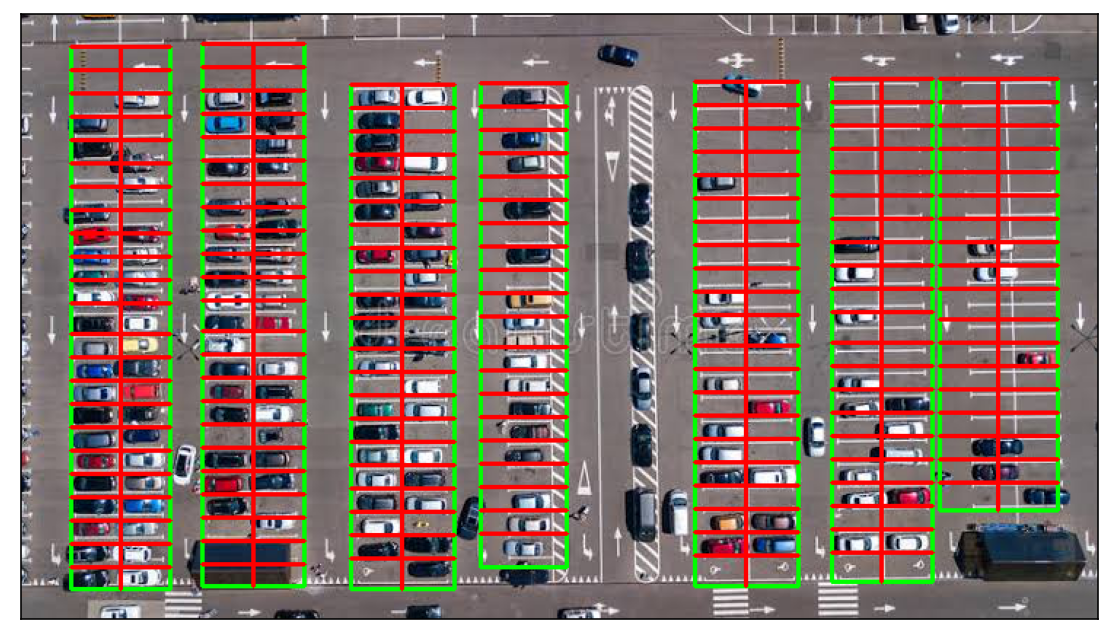

1


In [12]:
def draw_parking(image, rects, twoOrOne, make_copy = True, color=[255, 0, 0], thickness=2, save = True):
    if make_copy:
        new_image = np.copy(image)    
    gap = int(shortEdge)  #12.5 #15.5 # +0,5
    spot_dict = {} # maps each parking ID to its coords
    tot_spots = 0
    buff = int(shortEdge) + int(buffAdd) # 3
    avg_rect_size = 0

    print(len(twoOrOne))

    for key in rects:
        h = rects[key][3] - rects[key][1]
        w = rects[key][2] - rects[key][0]
        avg_rect_size += h * w
    avg_rect_size = avg_rect_size / len(rects)
    count = 0
    for key in rects:     
        # Horizontal lines
        tup = rects[key]
        x1 = int(tup[0]) - buff#+ adj_x1[key])
        x2 = int(tup[2]) + buff#+ adj_x2[key])
        y1 = int(tup[1])# + adj_y1[key])
        y2 = int(tup[3])# + adj_y2[key])
        
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)

        num_splits = int(abs(y2-y1)//gap)
        gapPlus = 0
        for i in range(0, num_splits):
            if num_splits//2 + 1 == i and gapPlus == 0:
                gapPlus += 5
            y = int(y1 + i*gap + gapPlus)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
     
        #draw vertical lines
        if not twoOrOne[count]:
            x = int((x1 + x2)/2)
            cv2.line(new_image, (x, y1), (x, y2), color, thickness)
            
        # Add up spots in this lane
        if twoOrOne[count]: 
            tot_spots += num_splits 
        else:
            tot_spots += 2*(num_splits )
            
        # Dictionary of spot positions
        if twoOrOne[count]: #if area < avg_rect_size:
            gapPlus = 0
            for i in range(0, num_splits):
                if num_splits//2 + 1 == i and gapPlus == 0:
                    gapPlus -= 4
                cur_len = len(spot_dict)
                y = (y1 + i*gap + gapPlus)
                spot_dict[(x1, y, x2, y+gap + gapPlus)] = cur_len +1        
        else:
            gapPlus = 0
            for i in range(0, num_splits):
                if num_splits//2 + 1 == i and gapPlus == 0:
                    gapPlus -= 2
                cur_len = len(spot_dict)
                y = y1 + i*gap + gapPlus
                x = (x1 + x2)/2
                spot_dict[(x1, y, x, y+gap + gapPlus)] = cur_len +1
                spot_dict[(x, y, x2, y+gap + gapPlus)] = cur_len +2
        count += 1

    print("total parking spaces: ", tot_spots, cur_len)
    if save:
        filename = 'with_parking.jpg'
        cv2.imwrite(filename, new_image)
    return new_image, spot_dict

delineated = []
spot_pos = []
for image, rects, twoOrOne in zip(test_images, rect_coords, rect_single):
    new_image, spot_dict = draw_parking(image, rects, twoOrOne)
    delineated.append(new_image)
    spot_pos.append(spot_dict)
    
show_images(delineated)
print(len(spot_pos))

In [13]:
final_spot_dict = spot_pos[0]

In [14]:
print(len(final_spot_dict))

274


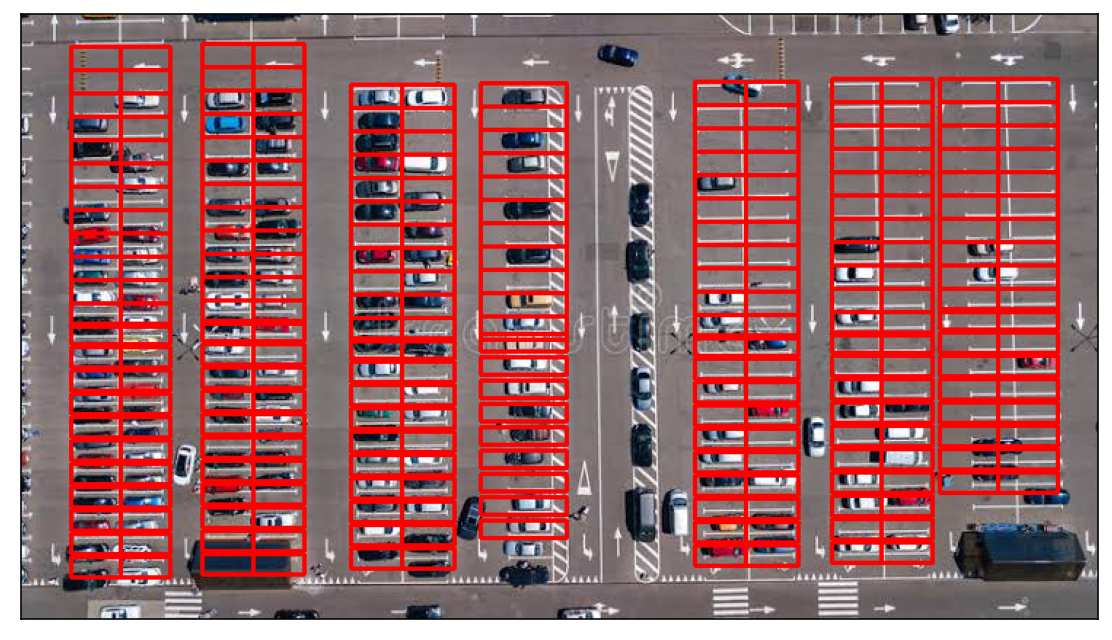

In [15]:
def assign_spots_map(image, spot_dict=final_spot_dict, make_copy = True, color=[255, 0, 0], thickness=2):
    if make_copy:
        new_image = np.copy(image)
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        cv2.rectangle(new_image, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
    return new_image

marked_spot_images = list(map(assign_spots_map, test_images))
show_images(marked_spot_images)

In [18]:
positions = []
for spot in final_spot_dict.keys():
    x1, y1, x2, y2 = spot
    positions.append((int(x1),int(y1)))

In [19]:
with open('carPositions', 'wb') as f:
    pickle.dump(positions, f)
with open('parkWidthHeight', 'wb') as f:
    pickle.dump([int(longEdge), int(shortEdge)], f)